In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv1D, UpSampling1D, Dropout, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

import numpy as np

import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

from time import time
import os

from scipy.signal import spectrogram, istft

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

import seaborn as sns

import pandas as pd

from matplotlib.colors import ListedColormap

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt


## Load data and preprocess

In [8]:
waveform_filename = 'hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms_PREPROCESSED.mseed'

if os.path.exists(waveform_filename):
    print('{} exists, loading'.format(waveform_filename))
    stream = obspy.read(waveform_filename)
    
else:
    print("{} doesn't exist, processing file".format(waveform_filename))
    stream = obspy.read('hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms.mseed')

    client = Client('IRIS')

    starttime = UTCDateTime('2018-04-01')
    endtime = UTCDateTime('2018-8-31')
    POHA = client.get_stations(network="IU", station="POHA", 
                               starttime=starttime, endtime=endtime,
                              level='response')

    print("Removing seismometer response...")
    stream.remove_response(POHA)
    print("Filtering waveforms...")
    stream.filter('bandpass', freqmin=3, freqmax=8, corners=2, zerophase=True)
    print("Normalizing waveforms...")
    stream.normalize()
    print("Done")

    stream.write('hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms_PREPROCESSED.mseed')
    
cat = obspy.core.event.read_events('hawaii_Apr-Aug-2018_mag1.5_POHA_catalog.xml')    

hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms_PREPROCESSED.mseed exists, loading


## Create Spectrograms

41474


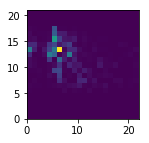

In [9]:
df = 20
trace_length = 40

spectrograms = []

for tr in stream:
    if len(tr.data) == trace_length*df:
        _, _, Sxx = spectrogram(tr.data, nperseg=int(df*2), scaling='spectrum')
        spectrograms.append(Sxx.T)
f = plt.figure(figsize=(2,2))    
plt.pcolormesh(spectrograms[10].T)
print(len(spectrograms))

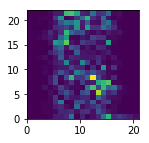

In [10]:
f = plt.figure(figsize=(2,2))
plt.pcolormesh(spectrograms[40000])

In [11]:
np.array(spectrograms).shape


(41474, 22, 21)

In [12]:
X = np.array(spectrograms)

X_train, X_val = train_test_split(X, test_size=0.05)

# Create a 1D causal convolutional autoencoder for seismic spectrogram feature extraction

based on https://blog.keras.io/building-autoencoders-in-keras.html, https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb

In [13]:
# Maybe I should class this

def build_model(latent_dims, input_shape, n_filters=32, dilation_rate=2, n_layers=4):
    
    # ENCODER
    encoder_input = Input(shape=input_shape)  # adapt this if using `channels_first` image data format
    x = encoder_input
    
    for i in [dilation_rate**i for i in range(n_layers)]:
        x = Conv1D(n_filters, 2, dilation_rate=i, activation='relu', padding='causal')(x)

    encode = Flatten()(x)
    encode = Dense(latent_dims)(encode)
    encode = Reshape((1,latent_dims))(encode)

    # DECODER
    #decoder_input = Input(shape=(1,latent_dims))
    decode = Dense(input_shape[0], activation='relu')(encode)
    decode = Reshape((input_shape[0],1))(decode)
    #x = decoder
    
    skips = []
    for i in [dilation_rate**i for i in range(n_layers)][::-1][:-1]:
        #last step should be a dilatation of 1, skip this to put a sigmoid activation on last layer
        lyr = Conv1D(n_filters, 2, dilation_rate=i,activation='relu', padding='causal')(decode)
        skips.append(lyr)
        decode = lyr
        #x = UpSampling1D(2)(x)      

    decode = Conv1D(n_filters, 2, dilation_rate=1, activation='sigmoid', padding='causal')(decode)
    decode = Dense(input_shape[1])(decode)

    encoder = Model(encoder_input, encode)
    #decoder = Model(decoder_input, decode)
    autoencoder = Model(encoder_input, decode)
    
    #decoder = Model(latent, decoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    #encoder.compile()
    
    return autoencoder, encoder #, decoder



In [14]:
n_filters = 64
latent_dims = 10
n_layers = 4
model_time = time()

input_shape = (spectrograms[0].shape[0], spectrograms[0].shape[1])
autoencoder, encoder = build_model(latent_dims, 
                                   (input_shape), 
                                   n_filters=n_filters, 
                                   n_layers=n_layers)

autoencoder.summary()

# create encoder model
inp = Input(shape=(10,))
m=inp
for layer in autoencoder.layers[8:]:
    m = layer(m)
    
decoder = Model(inp,m)

decoder.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 22, 21)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            2752      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 64)            8256      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 64)            8256      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 22, 64)            8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dens

## Setup the model and run
TODO: 
    - test multiple hyperparameters such as 
        - filters per layer
        - presence/absence of residual connections (not implemented)
        - presence/absence of full wavenet architecture (not implemented)

In [99]:
checkpoint = ModelCheckpoint('convolutional_spectrogram/weights/weights_{}layers_{}filters_{}latent_{}.hdf5'.format(n_layers, n_filters, latent_dims,model_time), 
                                monitor='loss', save_best_only=True)
tensorboard = TensorBoard(log_dir='convolutional_spectrogram/logs/log_{}layers_{}filters_{}latent_{}'.format(n_layers,n_filters, latent_dims, model_time))
#lrscheduler = LearningRateSchedular
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             patience=100, 
                             factor=0.5, 
                             min_delta=1e-7,
                            min_lr=1e-5)
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=1e-7, 
                          patience=200, 
                          verbose=1, 
                          mode='auto', 
                          restore_best_weights=True)
callbacks = [checkpoint, tensorboard, reduceLR, earlystop]

autoencoder.fit(X_train, X_train, 
                validation_data=(X_val,X_val),
                batch_size=512, 
                epochs=5000,  
                shuffle=True,
                callbacks=callbacks,
                verbose=0)

Restoring model weights from the end of the best epoch
Epoch 01606: early stopping


In [20]:
autoencoder.load_weights('convolutional_spectrogram/weights/weights_4layers_64filters_10latent_1563720708.2217884.hdf5')

### Example original and reconstructed spectrogram from training data set

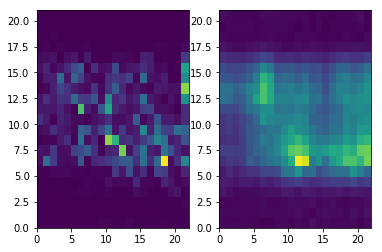

In [21]:
f, (ax1, ax2) = plt.subplots(1,2)
j = 1
ax1.pcolormesh(X_train[j].T)
predict = autoencoder.predict(X_train[j].reshape(1,X_train[j].shape[0],X_train[j].shape[1]))
ax2.pcolormesh(predict.T.reshape(X_train[j].shape[1],X_train[j].shape[0]))

### Example original and reconstructed spectrogram from validation data set

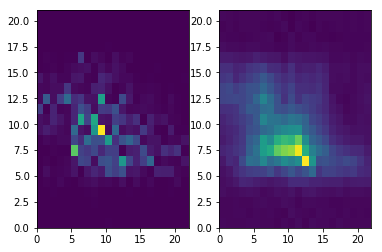

In [22]:
f, (ax1, ax2) = plt.subplots(1,2)
j = 1
ax1.pcolormesh(X_val[j].T)
predict = autoencoder.predict(X_val[j].reshape(1,X_val[j].shape[0],X_val[j].shape[1]))
ax2.pcolormesh(predict.T.reshape(X_val[j].shape[1],X_val[j].shape[0]))

### Calculate latent vectors from the dataset

In [23]:
encoder.compile(optimizer='adam', loss='mse')

In [24]:
latent_vectors = encoder.predict(X)
lvshape = latent_vectors.shape
latent_vectors = latent_vectors.reshape(lvshape[0],lvshape[2])

## K-means clustering

### Choose optimal number of clusters

In [111]:
scores = []
inertia = []

ks = range(2,12)

for num_clusters in ks:
    km = KMeans(num_clusters)
    cls = km.fit_predict(latent_vectors) 
    score = silhouette_score(latent_vectors, cls)
    #print("Silhouette score: {}".format(score))
    scores.append(score)
    #print("Inertia: {}".format(km.inertia_))
    inertia.append(km.inertia_)
    print("{} clusters fit".format(num_clusters))

2 clusters fit
3 clusters fit
4 clusters fit
5 clusters fit
6 clusters fit
7 clusters fit
8 clusters fit
9 clusters fit
10 clusters fit
11 clusters fit


Text(0, 0.5, 'Inertia')

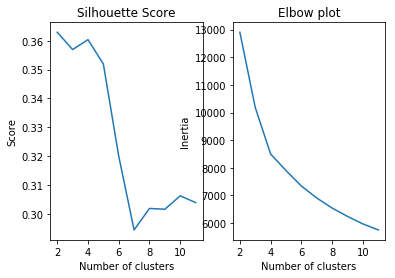

In [112]:
f, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(ks,scores)
ax1.set_title('Silhouette Score')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Score')

ax2.plot(ks, inertia)
ax2.set_title('Elbow plot')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Inertia')

### 4 clusters chosen

In [132]:
n_clusters = 4

kmeans = KMeans(n_clusters, random_state=1)

clusters = kmeans.fit_predict(latent_vectors)

cmap = sns.color_palette('muted',n_clusters)

### 2D PCA 

Text(0.5, 1.0, 'PCA dimensionality reduction of clustered earthquakes')

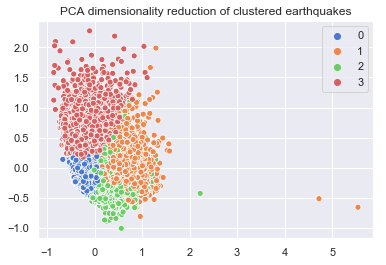

In [133]:
pca = PCA(n_components=2).fit_transform(latent_vectors)

sns.scatterplot(pca[:,0], pca[:,1], hue=clusters, palette=cmap)

plt.title('PCA dimensionality reduction of clustered earthquakes')




### 3D PCA

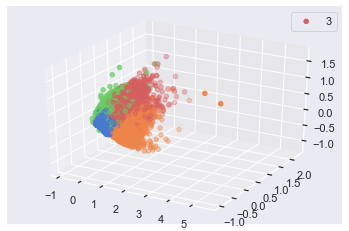

In [134]:
dpca = PCA(n_components=3).fit_transform(latent_vectors)

mcmap = ListedColormap(cmap)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dpca[:,0], dpca[:,1], dpca[:,2], c=clusters, label=clusters, cmap=mcmap)
ax.legend(clusters)


### T-sne

In [135]:
ts = TSNE(perplexity=40).fit_transform(latent_vectors[:5000])



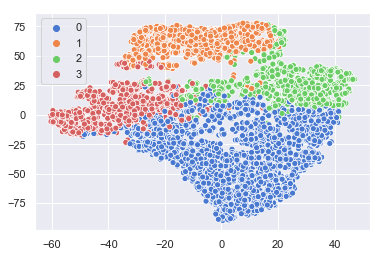

In [136]:
f = plt.figure()
sns.scatterplot(ts[:,0], ts[:,1], hue=clusters[:5000], palette=cmap)
#plt.scatter(ts[:,0],ts[:,1], c=clusters[:5000])

## Plot some spectrograms for each cluster

The following are plots of the original event spectrogram and waveform, along with their reconstructions from the model.  Note how the reconstructions capture a qualitatively smoothed representation of the original spectrograms.


In [137]:
# group spectrograms by cluster, also add event info

predicted = autoencoder.predict(X)

import pandas as pd

clustered = pd.DataFrame({'resource_id':[x.resource_id for x in cat],
                          'cluster':clusters, 
                          'spectrogram':[x for x in X[:]], 
                          'predicted':[x for x in predicted[:]],
                          'mag':[x.magnitudes[0].mag for x in cat],
                          'time':[x.origins[0].time for x in cat],
                          'depth':[x.origins[0].depth for x in cat],
                          'lat':[x.origins[0].latitude for x in cat],
                          'long':[x.origins[0].longitude for x in cat]})



In [138]:
clustered.to_pickle('convolutional_spectrogram_clusters.pkl')

In [139]:
clustered = pd.read_pickle('convolutional_spectrogram_clusters.pkl')

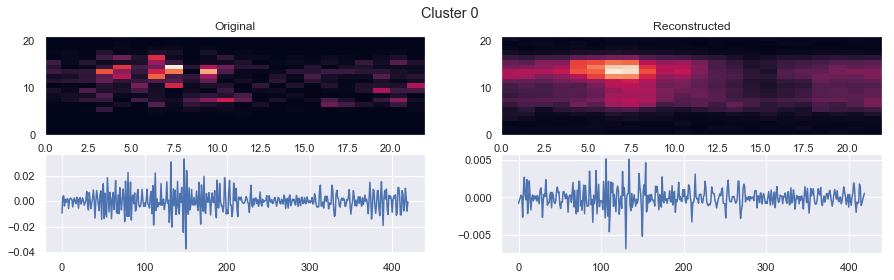

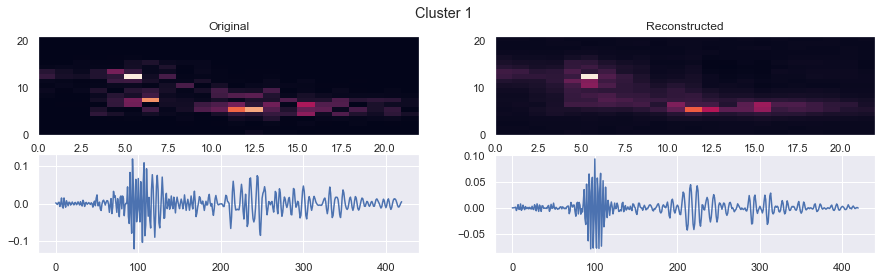

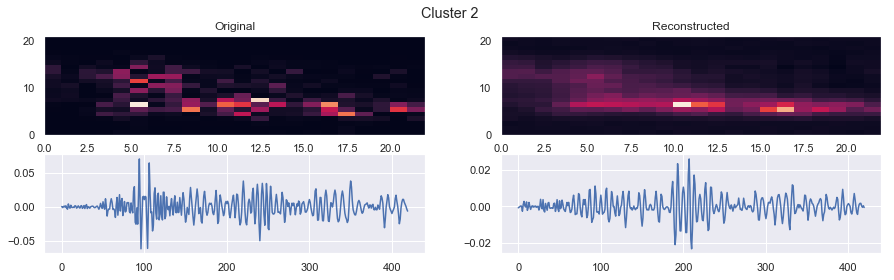

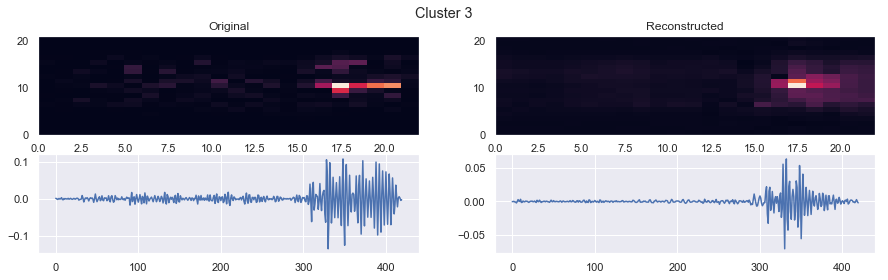

In [140]:
j = 100

for i in range(n_clusters):
    spect = clustered[clustered.cluster==i].iloc[j].spectrogram
    pred = clustered[clustered.cluster==i].iloc[j].predicted

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,4))
    f.suptitle('Cluster {}'.format(i))
    ax1.pcolormesh(spect.T)
    ax1.set_title('Original')
    ax2.pcolormesh(pred.T)
    ax2.set_title('Reconstructed')
    ax3.plot(istft(spect.T)[1])
    ax4.plot(istft(pred.T)[1])



## Reconstructed spectrograms of the cluster centers
The following reconstruct the centroid vector for each cluster into its spectrogram and waveform to visualize, in a sense, the average or prototypical spectrogram and waveform for each cluster.

In [141]:
centroid_spectrograms = decoder.predict(kmeans.cluster_centers_)

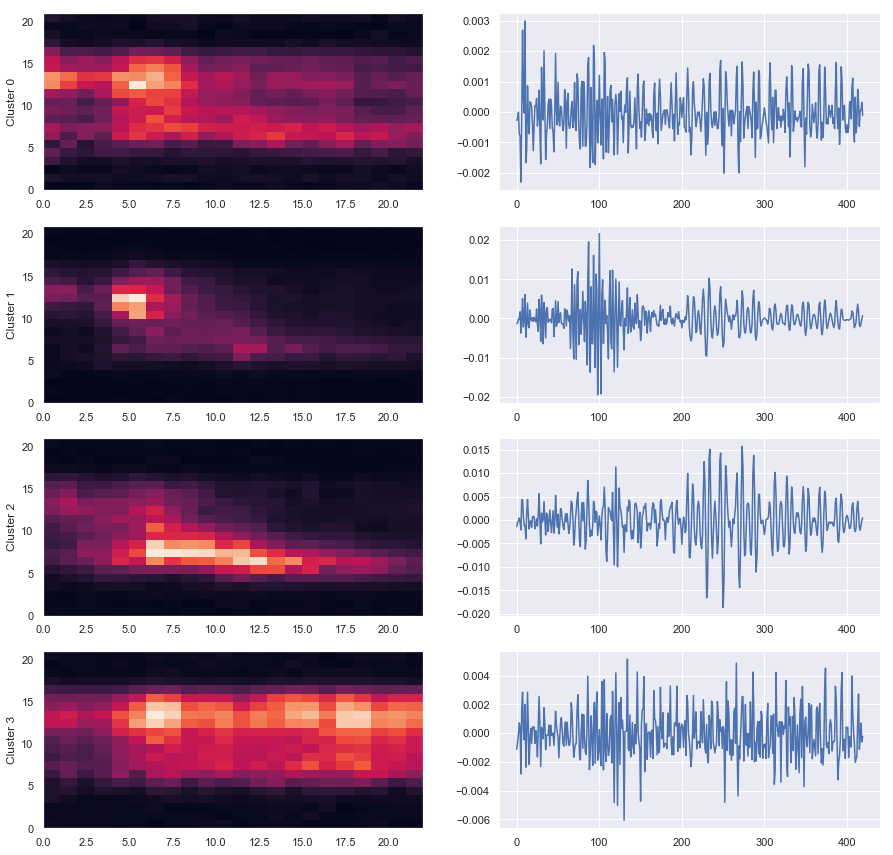

In [142]:
f, axes = plt.subplots(n_clusters,2, figsize=(15,15))

#f.set_title('Spectrograms and Waveforms for cluster centroid vectors')

for i, spect in enumerate(centroid_spectrograms):
    axes[i,0].pcolormesh(spect.T)
    axes[i,0].set_ylabel('Cluster {}'.format(i))
    axes[i,1].plot(istft(spect.T)[1])
    #axes[i,1].set_title('Cluster {} canonical centroid waveform’.format(i))



### Look at the latent vector centroids

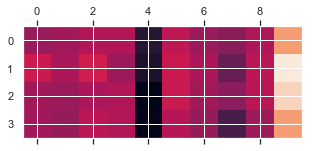

In [143]:
f,ax=plt.subplots(1,figsize=(5,5))
ax.matshow(kmeans.cluster_centers_)

In [144]:
pc = PCA(n_clusters)
pc.fit(kmeans.cluster_centers_)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<Figure size 432x288 with 0 Axes>

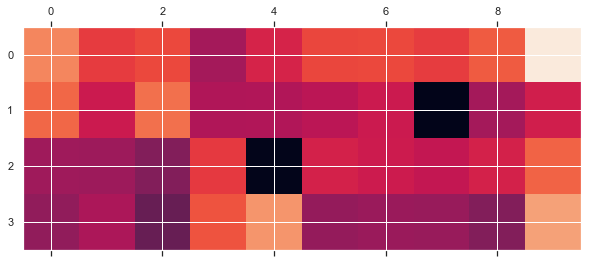

In [145]:
f=plt.figure()
plt.matshow(pc.components_)

## Look at magnitudes of each cluster, plot clusters in space and time

In [146]:
clustered.describe()

,cluster,mag,depth,lat,long
count,41474.000000,41474.000000,41474.000000,41474.000000,41474.000000
mean,1.118580,2.386256,1345.721560,19.404818,-155.265542
std,1.179671,0.433611,3502.146331,0.041853,0.072670
min,0.000000,1.500000,-3660.000000,18.664499,-156.301833
25%,0.000000,2.050000,290.000000,19.398500,-155.281662
50%,1.000000,2.360000,740.000000,19.408833,-155.272827
75%,2.000000,2.660000,1300.000000,19.417667,-155.264167
max,3.000000,6.900000,51700.000000,20.164000,-154.618833


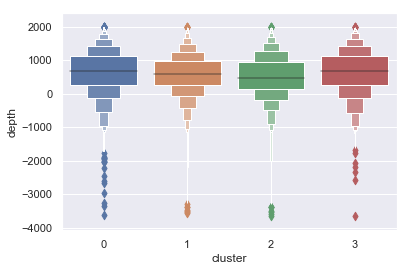

In [147]:
sns.boxenplot(x='cluster', y='depth', data=clustered[clustered.depth<2000])

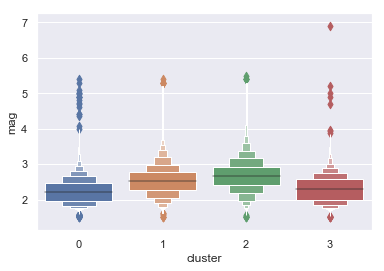

In [148]:
sns.boxenplot(x='cluster', y='mag', data=clustered)

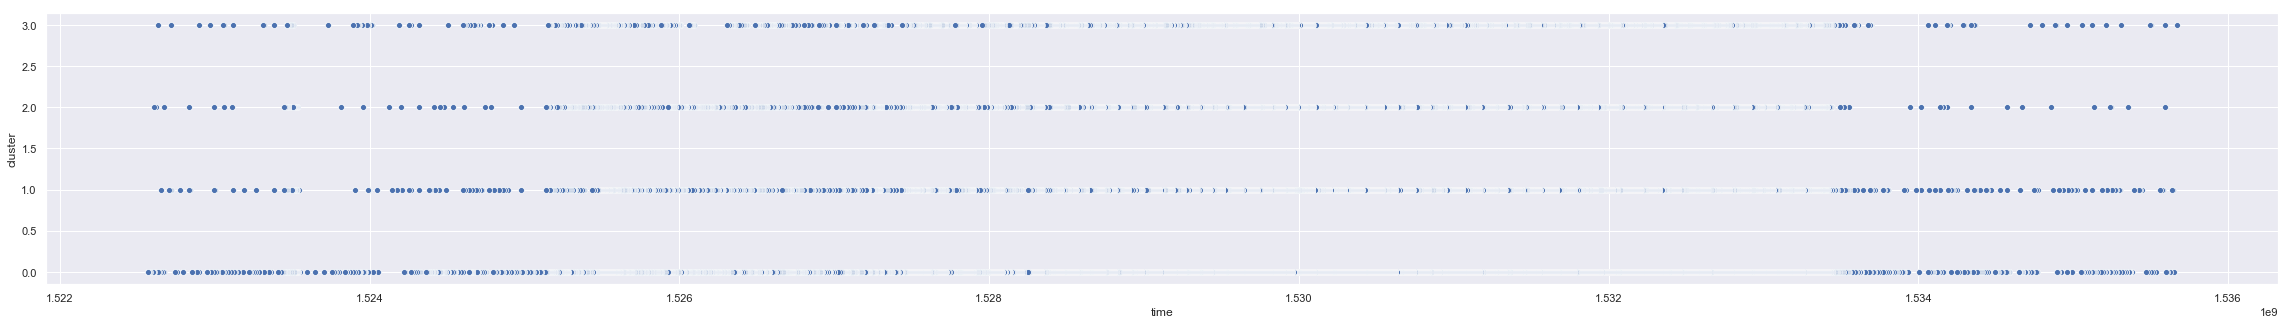

In [149]:
f = plt.figure(figsize=(40,5))
sns.scatterplot(clustered['time'], clustered['cluster'])

## Look at clusters with time

In [150]:
temporal_clusters = pd.DataFrame({'time':clustered.time,'cluster':clustered.cluster})
temporal_clusters.time = temporal_clusters.time.apply(lambda x: x.datetime)
temporal_clusters = temporal_clusters.set_index('time')
temporal_clusters = pd.get_dummies(temporal_clusters.cluster, prefix='cluster')

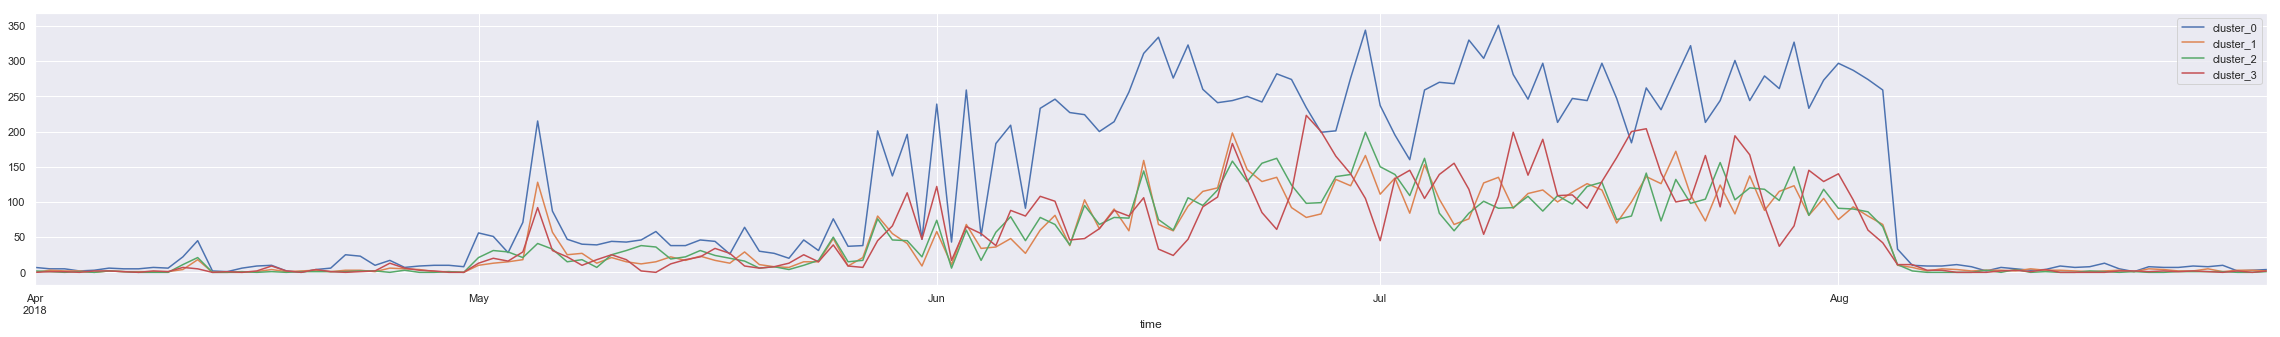

In [151]:
temporal_clusters.resample('D').sum().plot(figsize=(40,5))

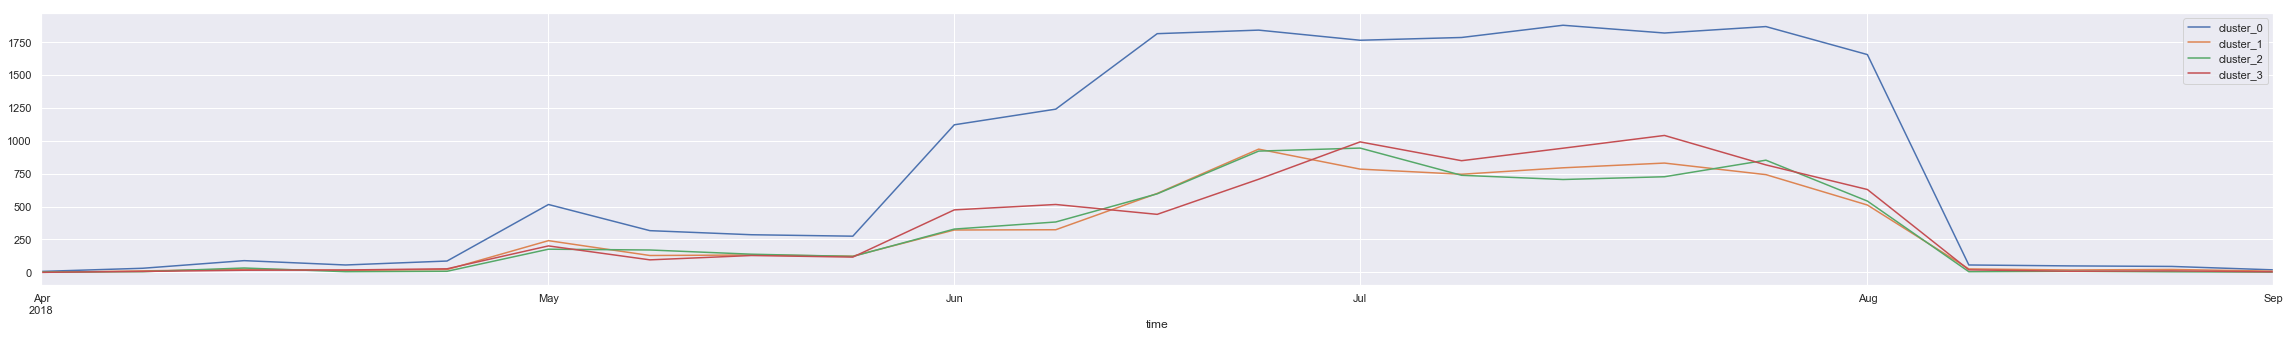

In [152]:
temporal_clusters.resample('W').sum().plot(figsize=(40,5))

In [159]:
t = temporal_clusters.resample('h').sum()

<BarContainer object of 3641 artists>

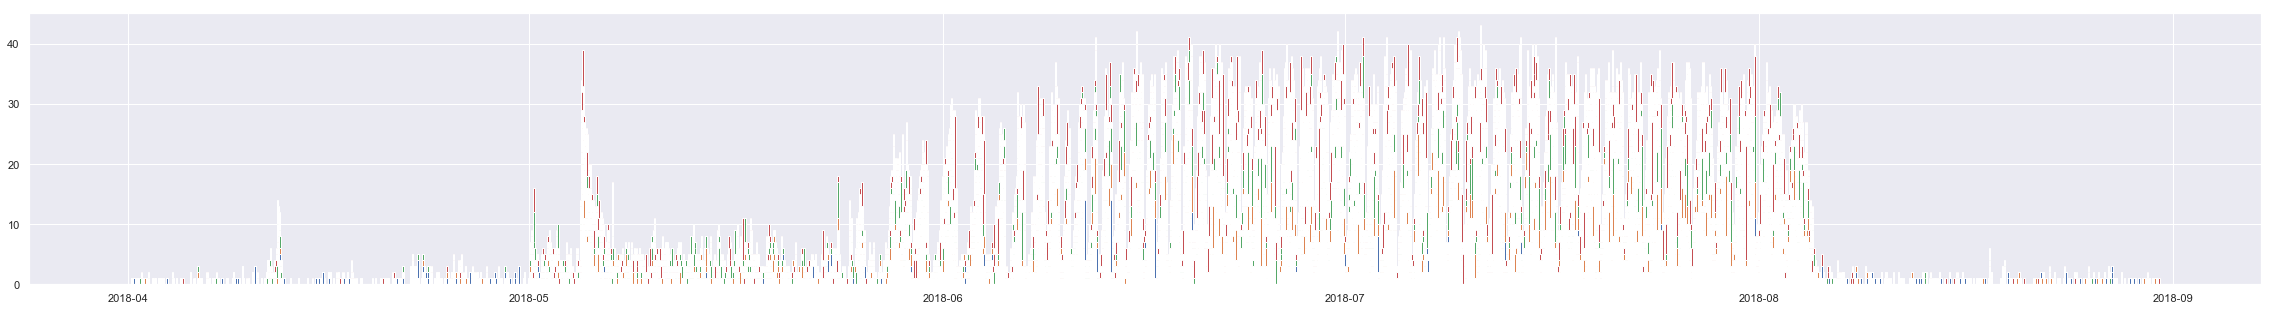

In [160]:
f,ax = plt.subplots(figsize=(40,5))
ax.bar(t.index, t.cluster_0, width=0.1)
bottom = t.cluster_0
ax.bar(t.index, t.cluster_1, width=0.1, bottom=bottom)
bottom += t.cluster_1
ax.bar(t.index, t.cluster_2, width=0.1,bottom=bottom)
bottom += t.cluster_2
ax.bar(t.index, t.cluster_3, width=0.1, bottom=bottom)

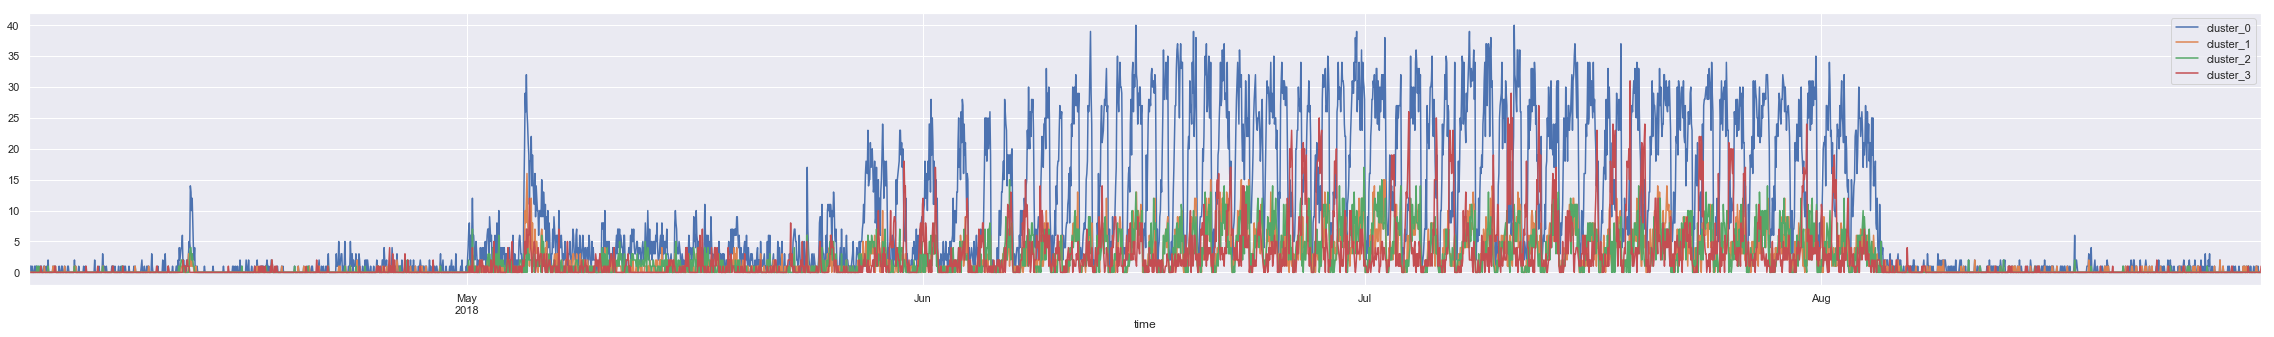

In [161]:
t.plot(figsize=(40,5))

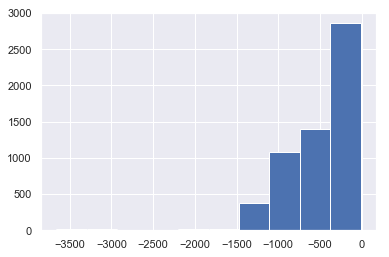

In [156]:
clustered.depth[clustered.depth<0].hist()

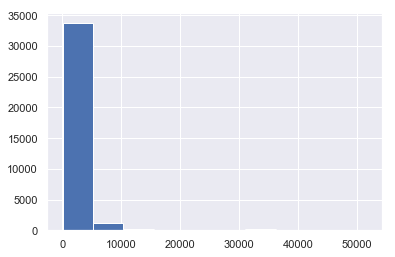

In [157]:
clustered.depth[clustered.depth>0].hist()

No handles with labels found to put in legend.


C:\Users\Nate\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


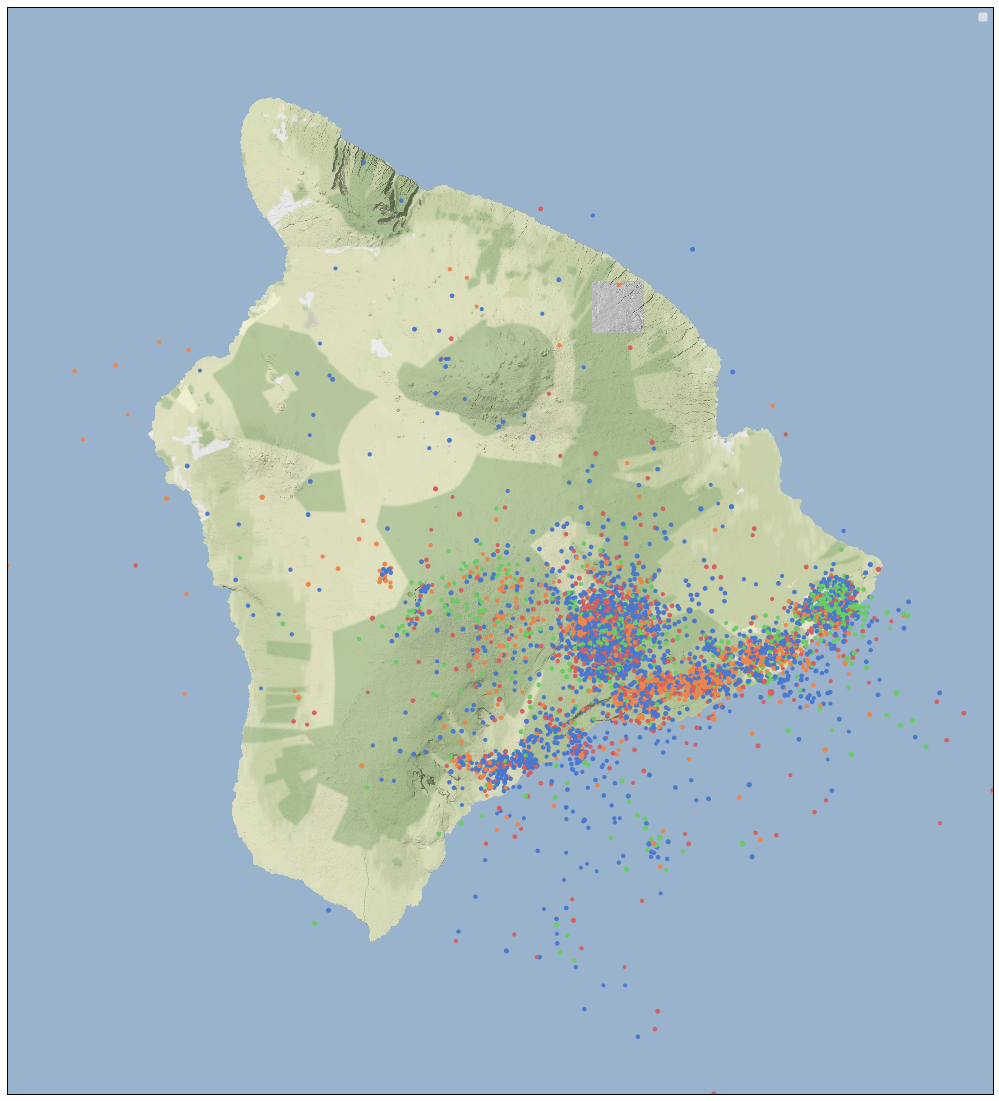

In [158]:
stamen_terrain = cimgt.Stamen('terrain-background')
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1,projection=stamen_terrain.crs)
#ax.coastlines(resolution='10m')
ax.set_extent((clustered.long.min(),clustered.long.max(),clustered.lat.min(),clustered.lat.max()+0.25),crs=ccrs.Geodetic())
ax.add_image(stamen_terrain, 12)
ax.legend()
plt.scatter(clustered.long,clustered.lat,
            transform=ccrs.PlateCarree(), 
            c=clustered.cluster,
            s=5*clustered.mag,
           cmap=mcmap)
#plt.show()

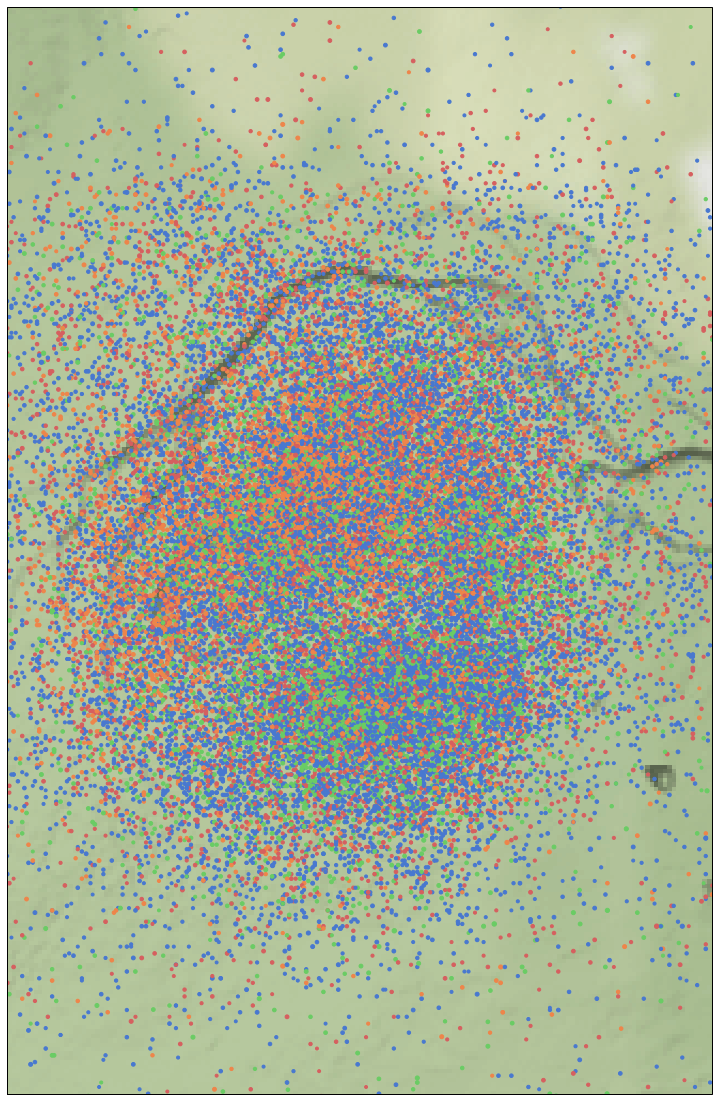

In [170]:
stamen_terrain = cimgt.Stamen('terrain-background')
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1,projection=stamen_terrain.crs)
#ax.coastlines(resolution='10m')
#ax.set_extent((-155.3,-155.245,19.37,19.45),crs=ccrs.Geodetic())
ax.add_image(stamen_terrain, 12)

plt.scatter(clustered.long,clustered.lat,
            transform=ccrs.PlateCarree(), 
            c=clustered.cluster,
            s=5*clustered.mag,
           cmap=mcmap)

In [164]:
clustered.lat.min(), clustered.lat.max()

(18.664498999999999, 20.164000000000001)

# Visualizing the filter weights

In [173]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in encoder.layers])
layer_dict.keys()

dict_keys(['input_1', 'conv1d_1', 'conv1d_2', 'conv1d_3', 'conv1d_4', 'flatten_1', 'dense_1', 'reshape_1'])

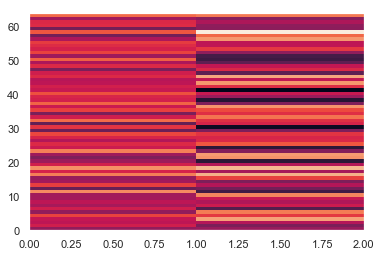

In [200]:
plt.pcolormesh(encoder.layers[4].get_weights()[0][:,:,63].T)


<tf.Tensor 'conv1d_1/Relu:0' shape=(?, 22, 64) dtype=float32>